In [42]:
import pandas as pd
import nltk
import string
import contractions
import datetime
import re
from transformers import pipeline
nltk.download(['wordnet', 'stopwords', 'punkt'])
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from typing import Optional
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from operator import itemgetter
from wordcloud import WordCloud
from fpdf import FPDF
from palettable.colorbrewer.qualitative import Set2_3

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [43]:
#Let us define some constants
READ_FROM_EXCEL = True
COMPANY_HANDLE = 'NikeSupport'  #'Uber_Support'

DATA UNDERSTANDING AND PREPARATION

In [44]:
#Load data from excel
data = pd.read_csv("twcs.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2811774 entries, 0 to 2811773
Data columns (total 7 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tweet_id                 int64  
 1   author_id                object 
 2   inbound                  bool   
 3   created_at               object 
 4   text                     object 
 5   response_tweet_id        object 
 6   in_response_to_tweet_id  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 131.4+ MB


In [45]:
data.head(5)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [46]:
#Get list of companies
companies_list = data[data['inbound'] == False]['author_id'].unique()
print(companies_list)

['sprintcare' 'Ask_Spectrum' 'VerizonSupport' 'ChipotleTweets'
 'AskPlayStation' 'marksandspencer' 'MicrosoftHelps' 'ATVIAssist'
 'AdobeCare' 'AmazonHelp' 'XboxSupport' 'AirbnbHelp' 'nationalrailenq'
 'AirAsiaSupport' 'Morrisons' 'NikeSupport' 'AskAmex' 'McDonalds'
 'YahooCare' 'AskLyft' 'UPSHelp' 'Delta' 'AppleSupport' 'Uber_Support'
 'Tesco' 'SpotifyCares' 'British_Airways' 'comcastcares' 'AmericanAir'
 'TMobileHelp' 'VirginTrains' 'SouthwestAir' 'AskeBay' 'hulu_support'
 'GWRHelp' 'sainsburys' 'AskPayPal' 'HPSupport' 'ChaseSupport' 'CoxHelp'
 'DropboxSupport' 'VirginAtlantic' 'BofA_Help' 'AzureSupport' 'AlaskaAir'
 'ArgosHelpers' 'Postmates_Help' 'AskTarget' 'GoDaddyHelp'
 'CenturyLinkHelp' 'AskPapaJohns' 'SW_Help' 'askpanera' 'Walmart'
 'USCellularCares' 'AsurionCares' 'GloCare' 'idea_cares' 'DoorDash_Help'
 'NeweggService' 'VirginAmerica' 'Safaricom_Care' 'DunkinDonuts'
 'Ask_WellsFargo' 'O2' 'TfL' 'asksalesforce' 'airtel_care' 'Kimpton'
 'AskCiti' 'IHGService' 'LondonMidland' 'Je

In [47]:
def get_company_tweets():
    company_tweets = data[data['author_id'] == COMPANY_HANDLE]
    company_interactions = data[data.text.str.contains(COMPANY_HANDLE)]
    tweets_by_company = pd.concat([company_tweets,company_interactions])
    return tweets_by_company

In [48]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [49]:
def basic_data_cleaning():
    #Lower caseing the text
    tweets_by_company['cleaned_text'] = tweets_by_company['text'].apply(lambda text: text.lower())
    #Removing contractions
    tweets_by_company['cleaned_text'] = tweets_by_company['cleaned_text'].apply(lambda text: contractions.fix(text))
    #Removing emojis
    tweets_by_company['cleaned_text'] = tweets_by_company['cleaned_text'].apply(lambda text: remove_emoji(text))
    #Removing @ from the tweet
    tweets_by_company['cleaned_text'] = tweets_by_company['cleaned_text'].apply(lambda text: text.replace("@", ""))
    #Removing punctuation
    tweets_by_company['cleaned_text'] = tweets_by_company['cleaned_text'].apply(lambda text: text.translate(str.maketrans("", "", string.punctuation)))
    return tweets_by_company

In [50]:
def create_interactions():
    #Find out the tweets involved in the conversations
    interactions = pd.DataFrame()
    for (index,user) in enumerate(users_list):
        inbound = tweets_by_company[tweets_by_company['author_id'] == user].sort_values(by=['created_at'])
        outbound = tweets_by_company.loc[(tweets_by_company['author_id'] == COMPANY_HANDLE) & (tweets_by_company.cleaned_text.str.contains(user))].sort_values(by=['created_at'])
        conversation_tweets = pd.concat([inbound, outbound])
        conversation_tweets = conversation_tweets.sort_values(by=['created_at'])
        conversation = '"'
        for index,tweet in conversation_tweets.iterrows():
            conversation =  conversation + tweet['author_id'] + ' : ' + tweet['cleaned_text'] + '\n'
        conversation =  conversation + '"'
        #Create a new object
        l = {'User' : inbound['author_id'].iloc[0], 'Company' : COMPANY_HANDLE, 'Conversation': conversation, 
            'First tweet by user at': inbound['created_at'].iloc[0], 'First response by company at': (outbound['created_at'].iloc[0] if len(outbound)>0 else 'No response'),
            'First tweet by User': inbound['cleaned_text'].iloc[0], 'First tweet by Company': (outbound['cleaned_text'].iloc[0] if len(outbound)>0 else 'No response'),  
            'No of interactions': len(conversation_tweets)}
        new_row = pd.DataFrame([l])
        interactions = pd.concat([interactions, new_row], ignore_index=True)
    return interactions

In [51]:
tweets_by_company = get_company_tweets()
company_users = users_list = tweets_by_company[tweets_by_company['inbound'] == True]['author_id'].unique()
number_of_users = len(company_users)
print("No of tweets related to " + COMPANY_HANDLE + " are " + str(len(tweets_by_company)))
print("No of users that raised issues are " + str(number_of_users))

No of tweets related to NikeSupport are 7240
No of users that raised issues are 1373


In [52]:
tweets_by_company = basic_data_cleaning() #Perform some basic cleaning for data exploration
interactions = create_interactions() #Create conversations from tweets
#interactions = pd.read_csv("Uber_Support.csv")

In [53]:
interactions.head(5)

,User,Company,Conversation,First tweet by user at,First response by company at,First tweet by User,First tweet by Company,No of interactions
0,115806,NikeSupport,"""115806 : nikesupport i am new to nike run clu...",Tue Oct 31 21:29:39 +0000 2017,Tue Oct 31 21:41:08 +0000 2017,nikesupport i am new to nike run club app sho...,115806 we got this both are beneficial to star...,5
1,123016,NikeSupport,"""123016 : nikesupport\narreglar aplicación no ...",Tue Oct 24 13:43:16 +0000 2017,Wed Nov 01 12:26:52 +0000 2017,nikesupport\narreglar aplicación no funciona n...,123016 hola gracias por tu opinión lo tomaremo...,4
2,123017,NikeSupport,"""NikeSupport : 123017 vamos a ayudarte prueba ...",Tue Oct 31 13:49:04 +0000 2017,Tue Oct 31 09:50:27 +0000 2017,nikesupport hola ha funcionado gracias por la ...,123017 vamos a ayudarte prueba a desisntala la...,3
3,123018,NikeSupport,"""123018 : nikesupport hey there this is the th...",Wed Nov 01 09:03:58 +0000 2017,Wed Nov 01 12:00:34 +0000 2017,nikesupport hey there this is the third time i...,123018 we are here for you due to limited char...,3
4,123645,NikeSupport,"""123645 : nikesupport zonas cardiacas en ntc e...",Wed Nov 01 07:12:56 +0000 2017,Wed Nov 01 13:02:24 +0000 2017,nikesupport zonas cardiacas en ntc en vivo se...,123645 hola gracias por tu opinión lo tomaremo...,3


DATA CLEANING

In [54]:
#Lets import all stopwords
stopwards_file = open("stopwords_all.txt", "r")
try:
    content = stopwards_file.read()
    stopwords_all = content.split("\n")
finally:
    stopwards_file.close()

In [55]:
def tokenize_tweets(tweet : str, extra_stops : Optional[list] = None) -> list[str]:
    # common stop words in the English language
    en_stopwords = stopwords.words('english')
    
    en_stopwords += stopwords_all

    if extra_stops:
        en_stopwords += extra_stops

    # stop words collection as a fast searchable set
    tweet_stopwords = set(en_stopwords)

    lmr = WordNetLemmatizer()

    # tokenize the text
    tweet_tokens = []
    for t in word_tokenize(tweet):
        if t.isalpha():
            t = lmr.lemmatize(t.lower())
            if t not in tweet_stopwords:
                tweet_tokens.append(t)
                
    return tweet_tokens

In [56]:
tweets = []
tweets_strings = []

for i in range(len(interactions)):
    article_tokens = tokenize_tweets(interactions.iloc[i]['First tweet by User'], extra_stops=[interactions.iloc[i]['User'], interactions.iloc[i]['Company'].lower()])
    tweets_strings.append(' '.join(article_tokens))
    tweets.append(article_tokens)

corpus_dict = Dictionary(tweets)
interactions['Cleaned first tweet'] = tweets_strings

print("Count of terms before filtering {}".format(len(corpus_dict)))
corpus_dict.filter_extremes(no_below=15, no_above=0.5)

print("Count of terms after filtering {}".format(len(corpus_dict)))

corpus = [corpus_dict.doc2bow(tweet) for tweet in tweets]

Count of terms before filtering 2560
Count of terms after filtering 90


MODELLING

In [57]:
n_topics = 3

# train an unsupervised model of k topics
lda = LdaModel(corpus, num_topics=n_topics, random_state=23, id2word=corpus_dict)

topics = lda.show_topics(num_topics=n_topics, num_words=15, formatted=False)
topics = sorted(topics, key=lambda x: int(x[0]))
print("Num topics {}".format(len(topics)))
topics

Num topics 3


[(0,
  [('app', 0.15221967),
   ('nike', 0.049896207),
   ('nrc', 0.043645673),
   ('running', 0.037241243),
   ('iphone', 0.03668819),
   ('watch', 0.028886147),
   ('error', 0.028572325),
   ('update', 0.026082331),
   ('marathon', 0.018971734),
   ('club', 0.017421434),
   ('mi', 0.017403457),
   ('android', 0.017084863),
   ('version', 0.015759626),
   ('activity', 0.015363158),
   ('plan', 0.014943585)]),
 (1,
  [('plan', 0.09805257),
   ('app', 0.060143676),
   ('email', 0.05589731),
   ('workout', 0.04111538),
   ('nike', 0.038603846),
   ('ntc', 0.03157658),
   ('hey', 0.026990324),
   ('nrc', 0.024457693),
   ('club', 0.023345556),
   ('start', 0.0227692),
   ('month', 0.019895878),
   ('data', 0.019238764),
   ('week', 0.019185038),
   ('en', 0.019019796),
   ('training', 0.018226637)]),
 (2,
  [('app', 0.11932247),
   ('watch', 0.078025065),
   ('nike', 0.07518111),
   ('apple', 0.049683467),
   ('time', 0.03990776),
   ('nrc', 0.031477407),
   ('doe', 0.02965425),
   ('phon

In [58]:
summarizer = pipeline("summarization", model="philschmid/bart-large-cnn-samsum")

def create_summaries(conversation):
    return summarizer(conversation)

In [59]:
topic_ids = []
for (index, c) in enumerate(corpus):
    topic_id = max(lda[c], key=itemgetter(1))[0]
    topic_ids.append(topic_id)

interactions['Topic Id'] =  topic_ids

In [60]:
#Create dataframes for each topics
topic_dataframes = list()   # an empty list
for i in range (len(topics)):
    topic_dataframes.append(interactions[interactions['Topic Id'] == i])

ANALYSIS

In [61]:
interactions['Created by Hours'] =  interactions['First tweet by user at'].apply(lambda x: pd.Timestamp(x).hour)
interactions['Created by Date'] =  interactions['First tweet by user at'].apply(lambda x: pd.Timestamp(x).day)
#Day of the week, monday is 0 and so on
interactions['Created by Day'] =  interactions['First tweet by user at'].apply(lambda x: pd.Timestamp(x).day_of_week)
interactions.head(5)

,User,Company,Conversation,First tweet by user at,First response by company at,First tweet by User,First tweet by Company,No of interactions,Cleaned first tweet,Topic Id,Created by Hours,Created by Date,Created by Day
0,115806,NikeSupport,"""115806 : nikesupport i am new to nike run clu...",Tue Oct 31 21:29:39 +0000 2017,Tue Oct 31 21:41:08 +0000 2017,nikesupport i am new to nike run club app sho...,115806 we got this both are beneficial to star...,5,nike club app start guided couch,0,21,31,1
1,123016,NikeSupport,"""123016 : nikesupport\narreglar aplicación no ...",Tue Oct 24 13:43:16 +0000 2017,Wed Nov 01 12:26:52 +0000 2017,nikesupport\narreglar aplicación no funciona n...,123016 hola gracias por tu opinión lo tomaremo...,4,arreglar aplicación funciona contabilizar los ...,0,13,24,1
2,123017,NikeSupport,"""NikeSupport : 123017 vamos a ayudarte prueba ...",Tue Oct 31 13:49:04 +0000 2017,Tue Oct 31 09:50:27 +0000 2017,nikesupport hola ha funcionado gracias por la ...,123017 vamos a ayudarte prueba a desisntala la...,3,hola funcionado gracias por ayuda,1,13,31,1
3,123018,NikeSupport,"""123018 : nikesupport hey there this is the th...",Wed Nov 01 09:03:58 +0000 2017,Wed Nov 01 12:00:34 +0000 2017,nikesupport hey there this is the third time i...,123018 we are here for you due to limited char...,3,hey time week doe register,1,9,1,2
4,123645,NikeSupport,"""123645 : nikesupport zonas cardiacas en ntc e...",Wed Nov 01 07:12:56 +0000 2017,Wed Nov 01 13:02:24 +0000 2017,nikesupport zonas cardiacas en ntc en vivo se...,123645 hola gracias por tu opinión lo tomaremo...,3,zona cardiacas en ntc en vivo sería excelente ...,1,7,1,2


In [62]:
#Let us find out if there are any tweets that were not answered by Nike
no_response_interactions = interactions[interactions['First response by company at'] == 'No response'].copy()
interactions_with_response = interactions[interactions['First response by company at'] != 'No response'].copy()
no_response_interactions_count = len(no_response_interactions)

In [63]:
interactions_with_response['TTR'] = interactions_with_response.apply(lambda x: pd.Timestamp(x['First response by company at']) - pd.Timestamp(x['First tweet by user at']), axis=1)
interactions_with_response['TTR_days'] =  interactions_with_response['TTR'].apply(lambda ttr: ttr.days)
interactions_with_response['TTR_seconds'] =  interactions_with_response['TTR'].apply(lambda x: round(x.total_seconds(),2))
#Dropping nulls and also filtering interactions which were not first initiated by the customer
interactions_with_response = interactions_with_response.dropna().reset_index(drop=True)
interactions_with_response = interactions_with_response[interactions_with_response['TTR_days'] >= 0]

In [64]:
#max time taken to respond
max_ttr_interaction = interactions_with_response[interactions_with_response['TTR']==interactions_with_response['TTR'].max()]['TTR']

#min time taken to respond
min_ttr_interaction = interactions_with_response[interactions_with_response['TTR']==interactions_with_response['TTR'].min()]['TTR']

#Finding average ttr
avg_time=pd.to_timedelta(pd.Series(interactions_with_response['TTR'])).mean()

str(avg_time)

'0 days 11:49:23.582542694'

In [65]:
#Getting min, avg and max ttr for each topis
ttrs_by_topic = [[],[],[]]
for i in range(3):
    topic_interactions = interactions_with_response[interactions_with_response['Topic Id']==i]
    max_ttr = topic_interactions[topic_interactions['TTR_seconds']==topic_interactions['TTR_seconds'].max()].iloc[0]['TTR_seconds']
    min_ttr = topic_interactions[topic_interactions['TTR_seconds']==topic_interactions['TTR_seconds'].min()].iloc[0]['TTR_seconds']
    avg_ttr = round(topic_interactions['TTR_seconds'].mean(), 1)
    ttrs_by_topic[0].append(min_ttr)
    ttrs_by_topic[1].append(avg_ttr)
    ttrs_by_topic[2].append(max_ttr)
ttrs_by_topic

[[73.0, 64.0, 77.0],
 [35468.9, 62567.0, 36382.1],
 [1901775.0, 4497343.0, 3023779.0]]

In [66]:
#First Contact Resolution
#It was either resolved on social media or the issue was taken offline individually
first_contact_resolution = interactions_with_response[interactions_with_response['No of interactions'] == 2].copy()
first_contact_resolution_count = len(first_contact_resolution)
print(first_contact_resolution_count)

405


In [67]:
# create data
topic_labels = ['Topic 0', 'Topic 1', 'Topic 2']

interactions_per_topic=[
    len(interactions_with_response[interactions_with_response['Topic Id']==0]),
    len(interactions_with_response[interactions_with_response['Topic Id']==1]),
    len(interactions_with_response[interactions_with_response['Topic Id']==2])]

first_contact_per_topic=[
    len(first_contact_resolution[first_contact_resolution['Topic Id']==0]),
    len(first_contact_resolution[first_contact_resolution['Topic Id']==1]),
    len(first_contact_resolution[first_contact_resolution['Topic Id']==2])]

no_response_per_topic=[
    len(no_response_interactions[no_response_interactions['Topic Id']==0]),
    len(no_response_interactions[no_response_interactions['Topic Id']==1]),
    len(no_response_interactions[no_response_interactions['Topic Id']==2])]

others_more_than_two_per_topic = np.subtract(interactions_per_topic, first_contact_per_topic)

print(interactions_per_topic)
print(first_contact_per_topic)
print(others_more_than_two_per_topic)
print(no_response_per_topic)

[464, 265, 325]
[183, 117, 105]
[281 148 220]
[14, 4, 9]


In [68]:
top_quickest_responses = interactions_with_response.sort_values(by=['TTR']).head(5).copy()
top_slowest_responses = interactions_with_response.sort_values(by='TTR', ascending=False).head(5).copy()
top_complex_responses = interactions_with_response.sort_values(by='No of interactions', ascending=False).head(3).copy()

In [69]:
top_complex_responses

,User,Company,Conversation,First tweet by user at,First response by company at,First tweet by User,First tweet by Company,No of interactions,Cleaned first tweet,Topic Id,Created by Hours,Created by Date,Created by Day,TTR,TTR_days,TTR_seconds
844,497574,NikeSupport,"""497574 : nikesupport device samsung galaxy j...",Mon Nov 06 01:21:12 +0000 2017,Mon Nov 06 16:57:56 +0000 2017,nikesupport device samsung galaxy j2\nos and...,497574 got it let us have you log outgt restar...,42,device samsung galaxy android marshmallow nrc ...,0,1,6,0,0 days 15:36:44,0,56204.0
12,125348,NikeSupport,"""125348 : nikesupport coz today i might not ha...",Fri Oct 27 00:22:55 +0000 2017,Fri Oct 27 15:07:00 +0000 2017,nikesupport coz today i might not have time to...,125348 please let us know how many runs are mi...,39,coz time missing data check doe training program,0,0,27,4,0 days 14:44:05,0,53045.0
225,188282,NikeSupport,"""188282 : nikesupport the recommendations work...",Fri Nov 10 14:47:04 +0000 2017,Fri Nov 10 16:25:56 +0000 2017,nikesupport the recommendations worked well wi...,188282 sounds good to us fernando let us know ...,35,recommendation running nrc app,0,14,10,4,0 days 01:38:52,0,5932.0


In [70]:
#top_complex_responses['Conversation summary'] =  top_complex_responses['Conversation'].apply(lambda x: create_summaries(x)[0]['summary_text'])

VISUALISATIONS

In [71]:
plt.style.use('ggplot')

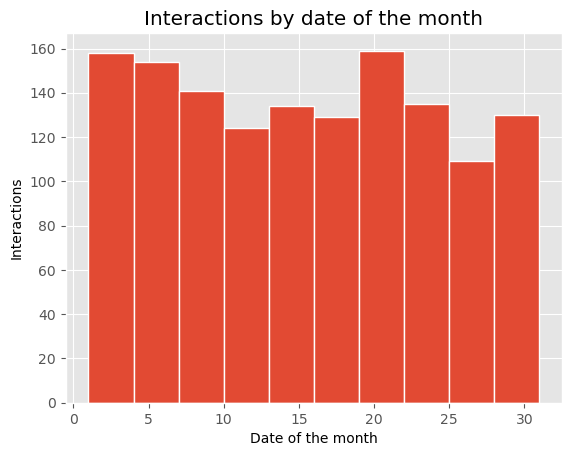

In [72]:
#Interactions by date of the month
plt.title('Interactions by date of the month')
plt.xlabel('Date of the month')
plt.ylabel('Interactions')
plt.hist(interactions['Created by Date'],edgecolor='white', linewidth=1)
plt.savefig("hist_by_months.jpg",  pad_inches=0.3, transparent=True)
plt.show()

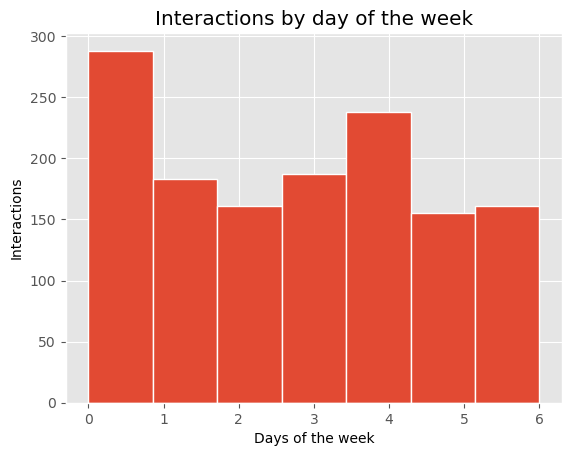

In [73]:
plt.title('Interactions by day of the week')
plt.xlabel('Days of the week')
plt.ylabel('Interactions')
plt.hist(interactions['Created by Day'],bins=7,edgecolor='white', linewidth=1)
plt.savefig("hist_by_week.jpg",  pad_inches=0.3, transparent=True)
plt.show()

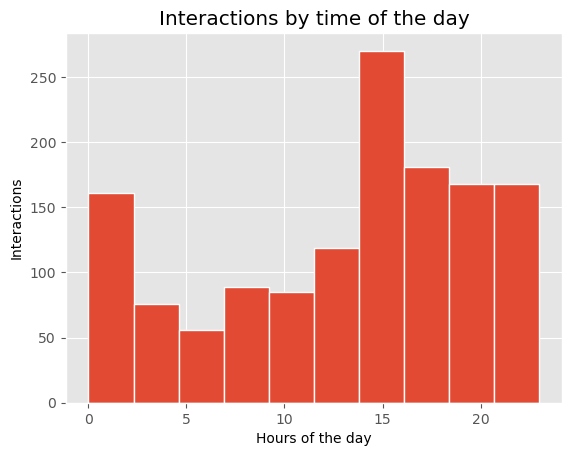

In [74]:
#Interactions by hours of the day
plt.title('Interactions by time of the day')
plt.xlabel('Hours of the day')
plt.ylabel('Interactions')
plt.hist(interactions['Created by Hours'],edgecolor='white', linewidth=1)
plt.savefig("hist_by_hour.jpg",  pad_inches=0.3, transparent=True)
plt.show()

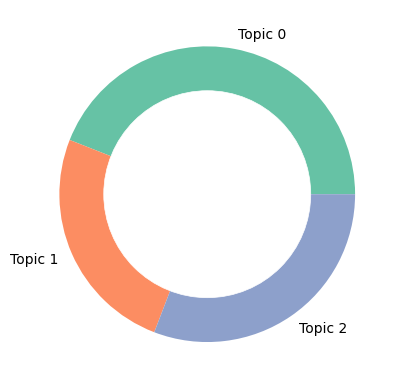

In [75]:
# Create donut plot for clusters distribution

# Create a pieplot
plt.pie(interactions_per_topic, labels=topic_labels, colors=Set2_3.hex_colors)

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle((0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.savefig("cluster_donuts.jpg")

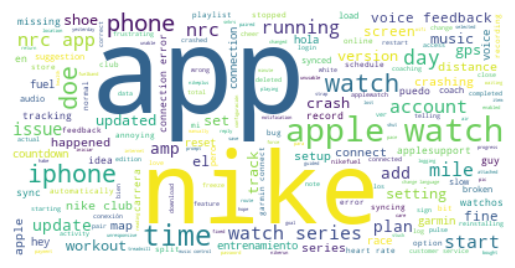

In [76]:
def create_word_clouds(topics):
    for i in range (len(topics)):
        wordcloud_text = ' '.join(topic_dataframes[i]['Cleaned first tweet'])

        # Generate a word cloud image
        wordcloud = WordCloud(background_color="white").generate(wordcloud_text)

        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        fig_name = "wordcloud" + str(i) + ".jpg"
        plt.savefig(fig_name)

create_word_clouds(topics)

In [77]:
ttrs_by_topic

[[73.0, 64.0, 77.0],
 [35468.9, 62567.0, 36382.1],
 [1901775.0, 4497343.0, 3023779.0]]

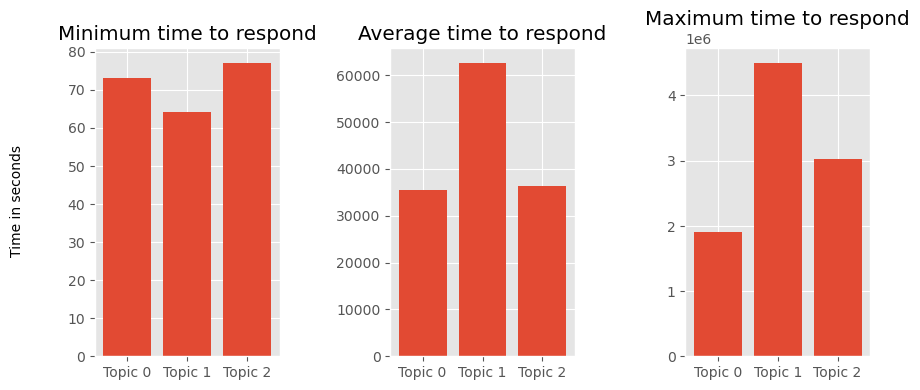

In [78]:
# Generate some random data for the plots
x = topic_labels
y1 = ttrs_by_topic[0]
y2 = ttrs_by_topic[1]
y3 = ttrs_by_topic[2]


# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Plot data on each subplot
axs[0].bar(x, y1)
axs[1].bar(x, y2)
axs[2].bar(x, y3)

# Set titles for each subplot
axs[0].set_title('Minimum time to respond')
axs[1].set_title('Average time to respond')
axs[2].set_title('Maximum time to respond')

# Set a common xlabel and ylabel for all subplots
fig.text(0.04, 0.5, 'Time in seconds', va='center', rotation='vertical')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.6)

plt.savefig("ttr_bar_graphs_parallel.jpg")

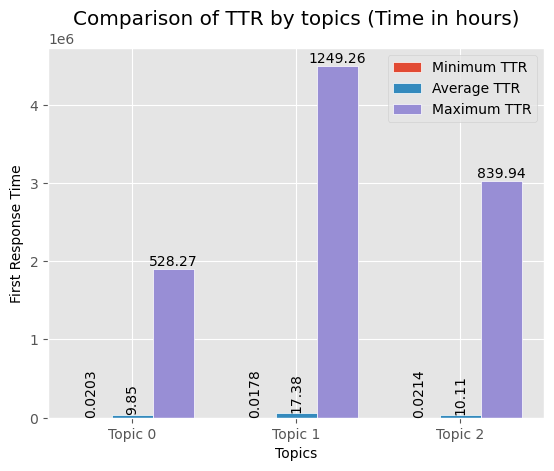

In [79]:
# TTR Graphs
group_names = ['Topic 0', 'Topic 1', 'Topic 2']
group1_values = ttrs_by_topic[0]
group2_values = ttrs_by_topic[1]
group3_values = ttrs_by_topic[2]

# Set the width of the bars
bar_width = 0.25

# Set the position of the bars on the x-axis
r1 = np.arange(len(group1_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.bar(r1, group1_values, width=bar_width, edgecolor='white', label='Minimum TTR')
plt.bar(r2, group2_values, width=bar_width, edgecolor='white', label='Average TTR')
plt.bar(r3, group3_values, width=bar_width, edgecolor='white', label='Maximum TTR')

# Add xticks on the middle of the group bars
plt.xlabel('Topics')
plt.xticks([r + bar_width for r in range(len(group1_values))], group_names)

# Add y-axis label
plt.ylabel('First Response Time')

# Add chart title
plt.title('Comparison of TTR by topics (Time in hours)')

# Add legend
plt.legend()

# Add labels for each bar
for i, value in enumerate(group1_values):
    plt.text(i, value, str(round(value/3600, 4)), ha='center', va='bottom', rotation=90)
for i, value in enumerate(group2_values):
    plt.text(i+bar_width, value, str(round(value/3600, 2)), ha='center', va='bottom', rotation=90)
for i, value in enumerate(group3_values):
    plt.text(i+2*bar_width, value, str(round(value/3600, 2)), ha='center', va='bottom')

plt.savefig("ttr_bar_graphs.jpg")

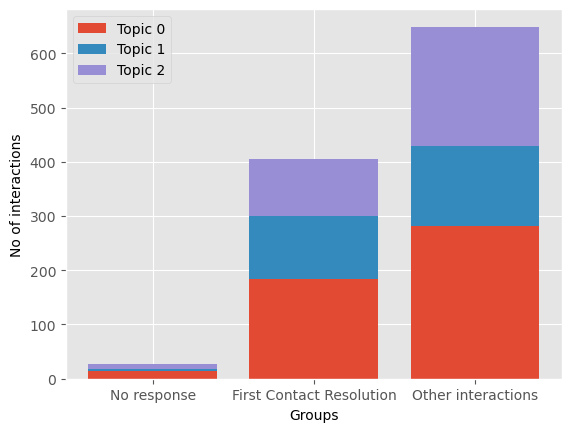

In [80]:

# create data
variables = ['No response', 'First Contact Resolution', 'Other interactions']

values = np.array([no_response_per_topic, first_contact_per_topic, others_more_than_two_per_topic])

# create stacked bar chart
fig, ax = plt.subplots()
ax.bar(variables, values[:,0], label=topic_labels[0])
ax.bar(variables, values[:,1], bottom=values[:,0], label=topic_labels[1])
ax.bar(variables, values[:,2], bottom=values[:,0]+values[:,1], label=topic_labels[2])

# add labels and legend
ax.set_xlabel('Groups')
ax.set_ylabel('No of interactions')
ax.legend()

plt.savefig("interactions_bar_graphs.jpg")

DEPLOYMENT

In [81]:
top_text = "Analysis of customer support interactions by " + COMPANY_HANDLE + " on Twitter has been performed."
topics_text = "The issues addressed by the customer support can be divided into three main topics. "
topics_text = topics_text + "The three topics named " + topic_labels[0] + " " + topic_labels[1] + " and " + topic_labels[2] + " have " + str(interactions_per_topic[0]) + ", " + str(interactions_per_topic[1]) + " and " + str(interactions_per_topic[2]) + " interactions respectively. "
topics_text = topics_text + "The distribution of issues can be broadly understood by analysing the word clouds of the topics. "
responses_0 = "The time taken by the company to respond to the tweets is an important metric. The average time taken by " + COMPANY_HANDLE + " to respond to a tweet is " + str(avg_time) + "."
responses_01 = "The tweet which has the smallest response time belong to Topic " + str(ttrs_by_topic[0].index(min(ttrs_by_topic[0]))) + ". "
responses_01 = responses_01 + "The tweet which has the highest average response time belong to Topic " + str(ttrs_by_topic[1].index(max(ttrs_by_topic[1]))) + ". "
responses_01 = responses_01 + "Whereas, the tweet which has the highest response time belong to Topic " + str(ttrs_by_topic[2].index(max(ttrs_by_topic[2]))) + ". "
responses_1 = "The responses by the company can be divided into three categories as shown in the graph."
responses_1 = responses_1 + " Topic " + str(no_response_per_topic.index(max(no_response_per_topic))) + " has maximum number of tweets which were not answered by the company (No response)."
responses_1 = responses_1 + " Topic " + str(first_contact_per_topic.index(max(first_contact_per_topic))) + " has maximum number of tweets which were either resolved by first contact or taken offline individually (First Contact Resolution)."
responses_1 = responses_1 + " Whereas Topic " + str(others_more_than_two_per_topic.argmax()) + " has maximum number of tweets which had more than two tweets as part of the interaction."
complex_queries = "Below are top 3 queries which had the most number of interactions. First tweet by the user and summary of the entire conversation can be seen in the table below:"

In [82]:
# cell height
ch = 8
class PDF(FPDF):
    def __init__(self):
        super().__init__()
    def header(self):
        self.set_font('Arial', '', 8)
        self.cell(0, 8, 'Report', 0, 1, 'C')
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 8)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')
    def create_table(self, header, data):
        # Set up table
        col_width = self.epw / len(header)
        row_height = self.font_size * 2
        self.set_font('Arial', 'B', 16)
        for h in header:
            self.cell(col_width, row_height, h, border=1)
        self.ln()
        
        # Add data
        self.set_font('Arial', '', 12)
        for row in data:
            for item in row:
                self.multi_cell(col_width, row_height, item, border=1)
            self.ln()
pdf = PDF()
pdf.add_page()
pdf.set_font('Arial', 'B', 24)
pdf.cell(w=0, h=15, txt="Twitter Customer Support Analysis for ", ln=1, align='C')
pdf.cell(w=0, h=15, txt=COMPANY_HANDLE, ln=1, align='C')
pdf.ln(ch)
pdf.ln(ch)
pdf.set_font('Arial', '', 12)
pdf.ln(ch)
pdf.multi_cell(w=0, h=5, txt=top_text)
pdf.ln(ch)
pdf.cell(w=80, h=ch, txt="Total number of issues", ln=0)
pdf.cell(w=30, h=ch, txt=str(number_of_users), ln=1)
pdf.ln(ch)

pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=15, txt="Interactions by day of the week and hour of the day", ln=1, align='C')
pdf.image('./hist_by_week.jpg', 
          x = 20, y = 120, w = 80, h = 0, type = 'JPG')
pdf.image('./hist_by_hour.jpg', 
          x = 110, y = 120, w = 80, h = 0, type = 'JPG')
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=15, txt="Analysis of types of issues raised", ln=1, align='C')
pdf.set_font('Arial', '', 12)
pdf.multi_cell(w=80, h=5, txt=topics_text)
pdf.image('./cluster_donuts.jpg', 
          x = 90, y = 210, w = 100, h = 0, type = 'JPG')
pdf.ln(ch)

# Add second page
pdf.add_page()

pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=15, txt="Word Clouds of the topics", ln=1, align='C')
pdf.image('./wordcloud0.jpg', 
          x = 10, y = 30, w = 100, h = 0, type = 'JPG')
pdf.image('./wordcloud1.jpg', 
          x = 100, y = 30, w = 100, h = 0, type = 'JPG')
pdf.ln(ch)
pdf.image('./wordcloud2.jpg', 
          x = 50, y = 90, w = 100, h = 0, type = 'JPG')
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.ln(ch)
pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=15, txt="Analysis of response time by the company", ln=1, align='C')
pdf.set_font('Arial', '', 10)
pdf.multi_cell(w=0, h=5, txt=responses_0)
pdf.set_xy(10, 190)
pdf.multi_cell(w=0, h=5, txt=responses_01)
pdf.image('./ttr_bar_graphs_parallel.jpg', 
          x = 20, y = 210, w = 160, h = 0, type = 'JPG')
pdf.ln(ch)

# Add third page
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=15, txt="Analysis of types of interactions", ln=1, align='C')
pdf.set_font('Arial', '', 10)
pdf.image('./interactions_bar_graphs.jpg', 
          x = 20, y = 30, w = 110, h = 0, type = 'JPG')
pdf.set_xy(130, 35)
pdf.multi_cell(w=50, h=5, txt=responses_1)
pdf.ln(ch)

pdf.set_font('Arial', 'B', 14)
pdf.cell(w=0, h=15, txt="Analysis of top 3 most complex queries", ln=1, align='C')
pdf.set_xy(10, 140)
pdf.set_font('Arial', '', 10)
pdf.multi_cell(w=0, h=5, txt=complex_queries)
pdf.set_xy(10, 160)

# Define the column widths
col_width = pdf.w / 3.5
row_height = pdf.font_size * 2

# Print table headers
pdf.cell(col_width, row_height, 'First tweet by user', border=1)
pdf.cell(col_width, row_height, 'No of interactions', border=1)
pdf.cell(col_width, row_height, 'Summary of conversation', border=1)
pdf.ln()


# Add the data rows
for index, row in top_complex_responses.iterrows():
    x = pdf.get_x()
    y = pdf.get_y()
    pdf.multi_cell(col_width, row_height, str(row['First tweet by User']), border=0)
    pdf.set_xy(x + col_width , y)
    x = pdf.get_x()
    y = pdf.get_y()
    pdf.multi_cell(col_width, row_height, str(row['No of interactions']), border=0, align='C')
    pdf.set_xy(x + col_width , y)
    pdf.multi_cell(col_width, row_height, str(row['First tweet by User']), border=0)
    pdf.ln(row_height)

pdf.output(f'./customer_service_report.pdf', 'F')

''